In [1]:
#-------------------------------This is approach - 1----------------------------------------

In [2]:
import keras
from PIL import Image, ImageOps
import cv2
import numpy as np
import glob
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os
%matplotlib inline
#---------------------These values are later used for making all pixels value either 0 or 1-----------
threshold = 127.0
max_value = 255.0
#----------------------------------------------------------------
#-----------------------loading training set images into X_train------------------------ 
filelist_t = sorted(glob.glob(r'/Users/apple/Desktop/Dataset_neuralnets_train/train/*.jpeg'))
#    making all the values either 0 0r 1
X_train = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_t ])
X_train = (X_train > threshold) * max_value
X_train = X_train / 255.
print (X_train[0].shape)

#-----------------------------------------------------------------
#----------------------loading testing set images into X_test------------------------------ 
filelist = sorted(glob.glob(r'/Users/apple/Desktop/Dataset_neuralnets_test/test/*.jpeg'))
X_test = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist ])
#    making all the values either 0 0r 1
X_test = (X_test > threshold) * max_value
X_test = X_test.astype(float) / 255.
Y_test = []


(16, 16)


In [3]:
#-----------------------Reshaping all the images from 16*16 to 256---------------------------
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)


Train dimension:
(10, 256)
Test dimension:
(20, 256)


In [4]:
#------------------Initialising weight matrix and filling them with random values between -1 and 1---------------
import random
weights = []
np.random.seed(0)
weights.append(np.random.uniform(-1,1,256))
weights = np.array(weights)
#-------------------Reshaping the weight matrix to make it compatible with X_train and X_test---------------------
weights = weights.reshape((256,))


In [5]:
#-------------------------Here we find the number of black pixels in each number of X_train-----------
UNIT_ARRAY = np.full((256,1),1, dtype = np.float32)
Y_train = [] # This has the number  black pixels for each input in X_train----------------------------
for i in range(10):
    temp = 0
    temp += np.dot(X_train[i],UNIT_ARRAY) + 1 
    Y_train.append(temp) #-------Here we calculating total number of 1s (that means number of whites)
Y_train = np.array(Y_train)
for i in range (10):
    Y_train[i] = 256 - Y_train[i] #--------So here we subtract it from 256 to get the number of blacks--
#print( Y_train)

In [6]:
#-----------------------Here we define our Activation function ------------------
def linear_activation(x):
    return x
    

In [7]:
#------------------------ Training of the model starts here ------------------
errors = [] 
No_of_black_pix = []
LEARNING_RATE = 0.001
for epochs in range(10000):

    for input_item,desired in zip(X_train, Y_train):
     
    #---------- Here we are implementing the SLP formula and calculate the SLP output-----------------
        OUTPUT = np.dot(input_item,weights) 
        OUTPUT = np.sum(OUTPUT)
#------------------Run OUTPUT through the linear activation function----------------------------------
        OUTPUT =linear_activation(OUTPUT)
#-------------------Calculate the ERROR generated-----------------------------------------------------
        ERROR = desired - OUTPUT       
#------------------Store the ERROR--------------------------------------------------------------------
        errors.append(ERROR)
        # Update the weights based on the delta rule
        weights = weights + LEARNING_RATE * ERROR * input_item
#-------------Here the number of black pixels are calculated with 
#--------------------------------------the new updated weights using the SLP formula------------------
for input_item  in X_train:
    temp_output = np.dot(input_item,weights) 
    temp_output = np.sum(temp_output)
#--------------This No_of_black_pix is used in the next function find_nearest in testing--------------
    No_of_black_pix.append(temp_output)

In [8]:
#--------------This is used in corresponding the output of the SLP 
#-------------------------------with one of the input using number of black pix----------------------
def find_nearest(x):
        temp = []
        for i in No_of_black_pix:
            temp.append(abs(i-x))
        k = temp.index(min(temp))
        return k

In [9]:
#----------------- This is the testing function which takes the-------------------------------------- 
#------------------------------------------numpy array set as input and returns the predicts-----------------------
def ModelTest(TestImageSet):
    K_train = ['B','E','F','H','I','3','4','5','9','0'] 
    test_output=[]
    predicts = [] #-------This contains the number between 1 to 10 as the approach-1 requires
    labels = []
    for input_item in (TestImageSet):

        # Feed this input forward and calculate the SLP output
        output = np.dot(input_item,weights) 
        output = np.sum(output)
        test_output.append(output)
        predicts.append(find_nearest(output))

    print (predicts)    
    for i in predicts:
         labels.append(K_train[i])
    print (labels)
    return predicts      

In [10]:
# ---------------------- Testing the model with our test set ------------------------
print("The predictions on the noiseless 20 data input are :")
ModelTest(X_test)

The predictions on the noiseless 20 data input are :
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']


[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]

In [11]:
#---------------------This function calculates ffa-----------------------------------
def calculate_ffa(input_image,output_image):
    wrong_blacks = 0.0
    whites = 0.0
    for i in range (256):
        if(input_image[i] == 0 and output_image[i]!=0):
            wrong_blacks = wrong_blacks + 1
    for j in range (256):
        if(input_image[j] == 1):
            whites = whites + 1        
    return wrong_blacks/whites
    
    

In [12]:
#---------------------This function calculates ffa for noisy images-------------------
def calculate_noisy_ffa(input_image,output_image):
    wrong_blacks = 0.0
    whites = 0.0
    for i in range (256):
        if(input_image[i] <= 0.5 and output_image[i]>0.5): 
            # we consider that if value is less than 0.5 then its black else its white
            wrong_blacks = wrong_blacks + 1
    for j in range (256):
        if(input_image[j] > 0.5):
            whites = whites + 1        
    return wrong_blacks/whites
    

In [13]:
#-----------------------This is just for example to check the functioning-----------------------------
calculate_ffa(X_test[6],X_train[7])

0.193717277486911

In [14]:
#---------------------This function calculates fh-----------------------------------
def calculate_fh(input_image,output_image):
    correct_blacks = 0.0
    blacks = 0.0
    for i in range (256):
        if(input_image[i] == 0):
            if(output_image[i] == 0):
                correct_blacks = correct_blacks + 1
    for j in range (256):
        if(input_image[j] == 0):
            blacks = blacks + 1        
    return correct_blacks/blacks
    

In [15]:
#---------------------This function calculates fh for noisy images-------------------
def calculate_noisy_fh(input_image,output_image):
    correct_blacks = 0.0
    blacks = 0.0
    for i in range (256):
        if(input_image[i] <= 0.5):# we consider that if value is less than 0.5 then its black else its white
            if(output_image[i] <= 0.5):
                correct_blacks = correct_blacks + 1
    for j in range (256):
        if(input_image[j] <= 0.5):
            blacks = blacks + 1        
    return correct_blacks/blacks

In [16]:
#-----------------------This is just for example to check the functioning-----------------------------
calculate_fh(X_train[5],X_test[13])

0.3157894736842105

In [17]:
print("The predictions on the noiseless 20 data input are :")
predicts = ModelTest(X_test)
print ()
print ()
ffa_list = []
fh_list = []
k=0
for i in range(20):
    index=predicts[k]
    ffa_list.append(calculate_ffa(X_test[i],X_train[index]))
    fh_list.append(calculate_fh(X_test[i],X_train[index]))
    k=k+1
print("The ffa values for Noiseless image input:")
print (ffa_list)
print("The fh values for Noiseless image input:")
print (fh_list)

The predictions on the noiseless 20 data input are :
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']


The ffa values for Noiseless image input:
[0.18316831683168316, 0.0, 0.11214953271028037, 0.14516129032258066, 0.0, 0.0, 0.18848167539267016, 0.0, 0.0, 0.1553398058252427, 0.15165876777251186, 0.107981220657277, 0.0, 0.0, 0.0, 0.2, 0.13425925925925927, 0.18652849740932642, 0.0, 0.0]
The fh values for Noiseless image input:
[0.3148148148148148, 1.0, 0.42857142857142855, 0.6142857142857143, 1.0, 1.0, 0.4461538461538462, 1.0, 1.0, 0.36, 0.28888888888888886, 0.46511627906976744, 1.0, 1.0, 1.0, 0.42424242424242425, 0.275, 0.42857142857142855, 1.0, 1.0]


Text(0.5, 1.0, 'A graph with fh on the ordinate axis and ffa on the abscissa')

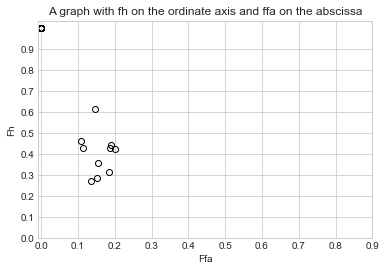

In [18]:
#----------------------The ffa vs fh graph plotting-------------
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.plot(ffa_list,fh_list,'o',color='black', markerfacecolor='none')
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
#-----------------Naming and labeling the graph---------------------
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('A graph with fh on the ordinate axis and ffa on the abscissa')

In [19]:
#-------------------This is the gaussian noise that will be added to the input dataset-----------------------
#----------------------This is traditional additive gaussian noise added to the image------------------------
def gaussy(X_noisy,std_dev,m):   
    X_noisy_temp = np.copy(X_noisy)
    random.seed(m)
    mean=0.0
    random_index=random.sample(range(256), 25)
    #print((random_index[0]))  
    np.random.seed(m)
    gauss=np.random.normal(mean,std_dev,(25,1,1))
    gauss=gauss.reshape(25,)
    #print(gauss)
#--------------------Normalization of pixel values to be in range (0,1)-------------------------------
    for j in range(20):
        for i in range(25):
            noisy_index=random_index[i]
            X_noisy_temp[j][noisy_index]=X_noisy_temp[j][noisy_index]+gauss[i]
#
    for j in range(20):
        for i in range(256):
            X_noisy_temp[j][i] = (X_noisy_temp[j][i] - np.amin(X_noisy_temp[j]))/(np.amax(X_noisy_temp[j]) - np.amin(X_noisy_temp[j]))
     
    #print (X_noisy[0])
    return X_noisy_temp

In [20]:
#----------------Different sets of noisy inputs are generated with different 
#-------------------------------------Standard Deviation and different seed for random number generator------
X_noisy1 = np.copy(X_test)
Noisy_1 = gaussy(X_noisy1,0.001,0)
Noisy_2 = gaussy(X_noisy1,0.002,1)
Noisy_3 = gaussy(X_noisy1,0.003,2)
Noisy_4 = gaussy(X_noisy1,0.005,3)
Noisy_5 = gaussy(X_noisy1,0.01,4)
Noisy_6 = gaussy(X_noisy1,0.02,5)
Noisy_7 = gaussy(X_noisy1,0.03,6)
Noisy_8 = gaussy(X_noisy1,0.05,7)
Noisy_9 = gaussy(X_noisy1,0.1,8)

In [21]:
#--------------- This is just for seeing if the noise induced input data 
#---------------------------------------is different for different Standard Deviations-----------
#print(Noisy_1[0])
#print(Noisy_8[0])

In [22]:
#-----------------Below two lists contain all the ffa and fh values of all the noisy levels 
#------------------------------------------ can be accessed by using [a:b]-------------------------
ffa_noisy_list = [] # total 180 values = 20 data  * 9 (noise levels)
fh_noisy_list = [] # total 180 values = 20 data * 9 (noise levels)
print("predictions for NOISY_1:")
predicts1 = ModelTest(Noisy_1)
print("predictions for NOISY_2:")
predicts2 = ModelTest(Noisy_2)
print("predictions for NOISY_3:")
predicts3 = ModelTest(Noisy_3)
print("predictions for NOISY_4:")
predicts4 = ModelTest(Noisy_4)
print("predictions for NOISY_5:")
predicts5 = ModelTest(Noisy_5)
print("predictions for NOISY_6:")
predicts6 = ModelTest(Noisy_6)
print("predictions for NOISY_7:")
predicts7 = ModelTest(Noisy_7)
print("predictions for NOISY_8:")
predicts8 = ModelTest(Noisy_8)
print("predictions for NOISY_9:")
predicts9 = ModelTest(Noisy_9)

Predicts = [predicts1,predicts2,predicts3,predicts4,predicts5,predicts6,predicts7,predicts8,predicts9] 
Noisy_list = [Noisy_1,Noisy_2,Noisy_3,Noisy_4,Noisy_5,Noisy_6,Noisy_7,Noisy_8,Noisy_9]
#------------------------appending all ffa fh of all noise levels into
#----------------------------------------------corresponding ffa_noisy_list and fh_noisy_list---------------------
for i,j in zip(Predicts,Noisy_list):
    h=0
    for k in range(20): 
        index= i[h]
        ffa_noisy_list.append(calculate_noisy_ffa(j[k],X_train[index]))
        fh_noisy_list.append(calculate_noisy_fh(j[k],X_train[index]))
        h=h+1
print('-' * 100)
#-----------------------The below are the predictions and their respective labels
#-----------------------------------and the correct ouputd are ['A','B','C','D','E'.....,'0']-----------------

predictions for NOISY_1:
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']
predictions for NOISY_2:
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']
predictions for NOISY_3:
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']
predictions for NOISY_4:
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 9, 5, 6, 7, 1, 6, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', '0', '3', '4', '5', 'E', '4', 'F', '9', '0']
predictions for NOISY_5:
[1, 0, 9, 3, 1, 2, 3, 3, 4, 3, 7, 1, 5, 6, 2, 1, 4, 2, 8, 9]
['E', 'B', '0', 'H', 'E', 'F', 'H', 'H', 'I', 'H', '5', 'E', '3', '4', 'F', 'E', 'I', 'F', '9', '0']
predictions for NOISY_6:
[1, 0, 9, 3, 6, 5, 3, 3, 7, 3, 2, 1, 5, 

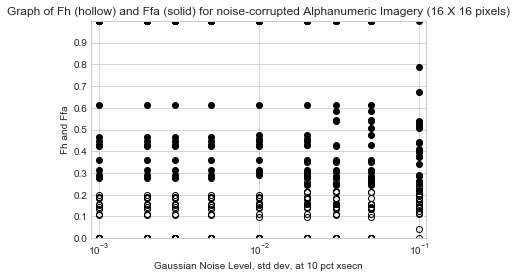

In [23]:
#----------------------The plotting of the ffa,fh vs SD is implemented below----------------------------

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

plt.style.use('seaborn-whitegrid')

#---------------------------This is for the Standard deviation 0.001-----------------------------
for i in range(0,20):
    a = i
    b = (i+1) 
    plt.plot(0.001,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.001,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.002-----------------------------
for i in range(20,40):
    a = i
    b = (i+1) 
    plt.plot(0.002,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.002,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.003-----------------------------
for i in range(40,60):
    a = i
    b = (i+1) 
    plt.plot(0.003,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.003,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.005-----------------------------
for i in range(60,80):
    a = i
    b = (i+1) 
    plt.plot(0.005,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.005,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.01-----------------------------
for i in range(80,100):
    a = i
    b = (i+1) 
    plt.plot(0.01,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.01,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.02-----------------------------
for i in range(100,120):
    a = i
    b = (i+1) 
    plt.plot(0.02,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.02,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.03-----------------------------
for i in range(120,140):
    a = i
    b = (i+1) 
    plt.plot(0.03,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.03,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.05-----------------------------
for i in range(140,160):
    a = i
    b = (i+1) 
    plt.plot(0.05,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.05,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.1------------------------------
for i in range(160,180):
    a = i
    b = (i+1) 
    plt.plot(0.1,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.1,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
    
#--------------The x axis is logarithmically scaled as mentioned in the  requirements----------------    
plt.xscale('log')
plt.yticks(np.arange(0,1,0.1))
plt.xlim([0.0009,0.1101])
plt.ylim([0,1])
#--------------Naming of the graph------------------
plt.xlabel('Gaussian Noise Level, std dev, at 10 pct xsecn')
plt.ylabel('Fh and Ffa')
plt.title('Graph of Fh (hollow) and Ffa (solid) for noise-corrupted Alphanumeric Imagery (16 X 16 pixels)')
plt.show()